In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector

from imblearn.under_sampling import RandomUnderSampler
plt.rcParams.update({'font.size': 15})

import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [216]:
column_names = [
    'name', 'landmass', 'zone', 'area', 'population',
    'language', 'religion', 'bars', 'stripes', 'colours',
    'red', 'green', 'blue', 'gold', 'white',
    'black', 'orange', 'mainhue', 'circles', 'crosses',
    'saltires', 'quarters', 'sunstars', 'crescent', 'triangle',
    'icon', 'animate', 'text', 'topleft', 'botright'
]

flags_df = pd.read_csv('./Data/flag.csv', names=column_names)
flags_df.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


In [217]:
## Создание функции для подсчета метрик
result_table = pd.DataFrame()

def get_metrics(y_true, y_pred, processing_name=None):
    result_data = {
        'processing_name': [processing_name],
        'accuracy': [accuracy_score(y_pred, y_true)],
        'recall': [recall_score(y_pred, y_true, average='macro')],
        'precision': [precision_score(y_pred, y_true, average='macro')],
        'f1_score': [f1_score(y_pred, y_true, average='macro')]
    }
    return pd.DataFrame(data=result_data)

## 1. EDA

### 1.1 Проверка на пропуски

In [218]:
flags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        194 non-null    object
 1   landmass    194 non-null    int64 
 2   zone        194 non-null    int64 
 3   area        194 non-null    int64 
 4   population  194 non-null    int64 
 5   language    194 non-null    int64 
 6   religion    194 non-null    int64 
 7   bars        194 non-null    int64 
 8   stripes     194 non-null    int64 
 9   colours     194 non-null    int64 
 10  red         194 non-null    int64 
 11  green       194 non-null    int64 
 12  blue        194 non-null    int64 
 13  gold        194 non-null    int64 
 14  white       194 non-null    int64 
 15  black       194 non-null    int64 
 16  orange      194 non-null    int64 
 17  mainhue     194 non-null    object
 18  circles     194 non-null    int64 
 19  crosses     194 non-null    int64 
 20  saltires  

### 1.2 Визулализация

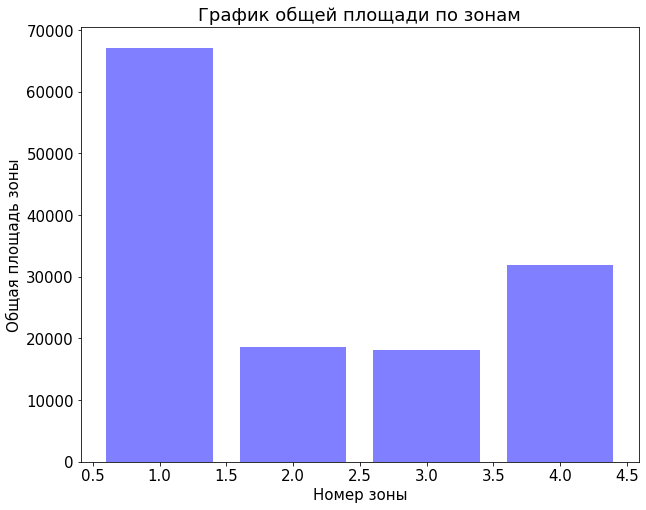

In [219]:
group_by_zone_df = flags_df.groupby('zone').agg({'area': 'sum'}).reset_index()
plt.figure(figsize=(10, 8))
plt.bar(
    group_by_zone_df['zone'],
    group_by_zone_df['area'],
    color='blue',
    alpha=0.5
)
plt.title('График общей площади по зонам')
plt.xlabel('Номер зоны')
plt.ylabel('Общая площадь зоны')
plt.show()

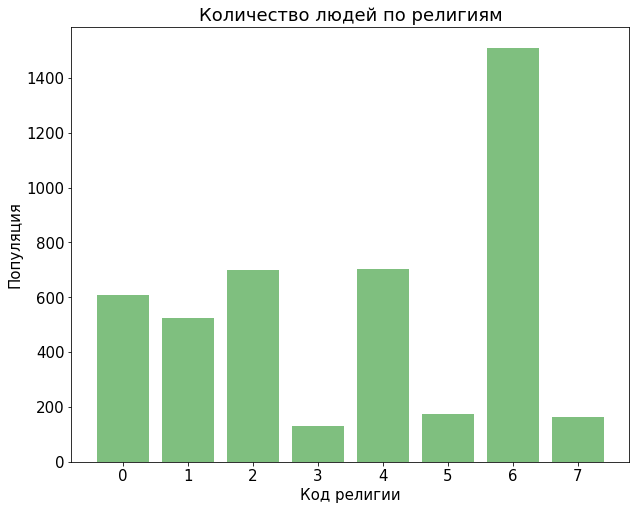

In [220]:
group_by_religion = flags_df.groupby('religion').agg({'population': 'sum'}).reset_index()
plt.figure(figsize=(10, 8))
plt.bar(
    group_by_religion['religion'],
    group_by_religion['population'],
    color='green',
    alpha=0.5
)
plt.title('Количество людей по религиям')
plt.xlabel('Код религии')
plt.ylabel('Популяция')
plt.show()

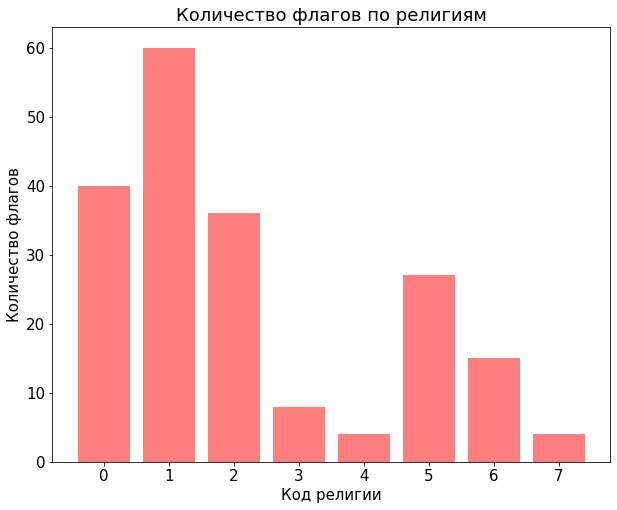

In [221]:
group_by_religion = flags_df.groupby('religion').agg({'population': 'count'}).reset_index()
plt.figure(figsize=(10, 8))
plt.bar(
    group_by_religion['religion'],
    group_by_religion['population'],
    color='red',
    alpha=0.5
)
plt.title('Количество флагов по религиям')
plt.xlabel('Код религии')
plt.ylabel('Количество флагов')
plt.show()

## 2. Разделение данных на тренировочный и тестовый набор данных

### 2.1 Кодирование категориальных переменных

In [222]:
flags_df['name'] = LabelEncoder().fit_transform(flags_df['name'])
flags_df['topleft'] = LabelEncoder().fit_transform(flags_df['topleft'])
flags_df['botright'] = LabelEncoder().fit_transform(flags_df['botright'])
flags_df['mainhue'] = LabelEncoder().fit_transform(flags_df['mainhue'])

In [223]:
X = flags_df.drop('religion', axis=1)
y = flags_df['religion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Обучение модели без её оптимизации и обработки данных

### 3.1 Обучим модель лочистической регрессии

In [224]:
log_reg_model = LogisticRegression().fit(X_train, y_train)
y_true = y_test
y_pred = log_reg_model.predict(X_test)

In [225]:
result_table = pd.concat([result_table, get_metrics(y_true, y_pred, 'without proccesing')])

## 4. Матрица корреляций

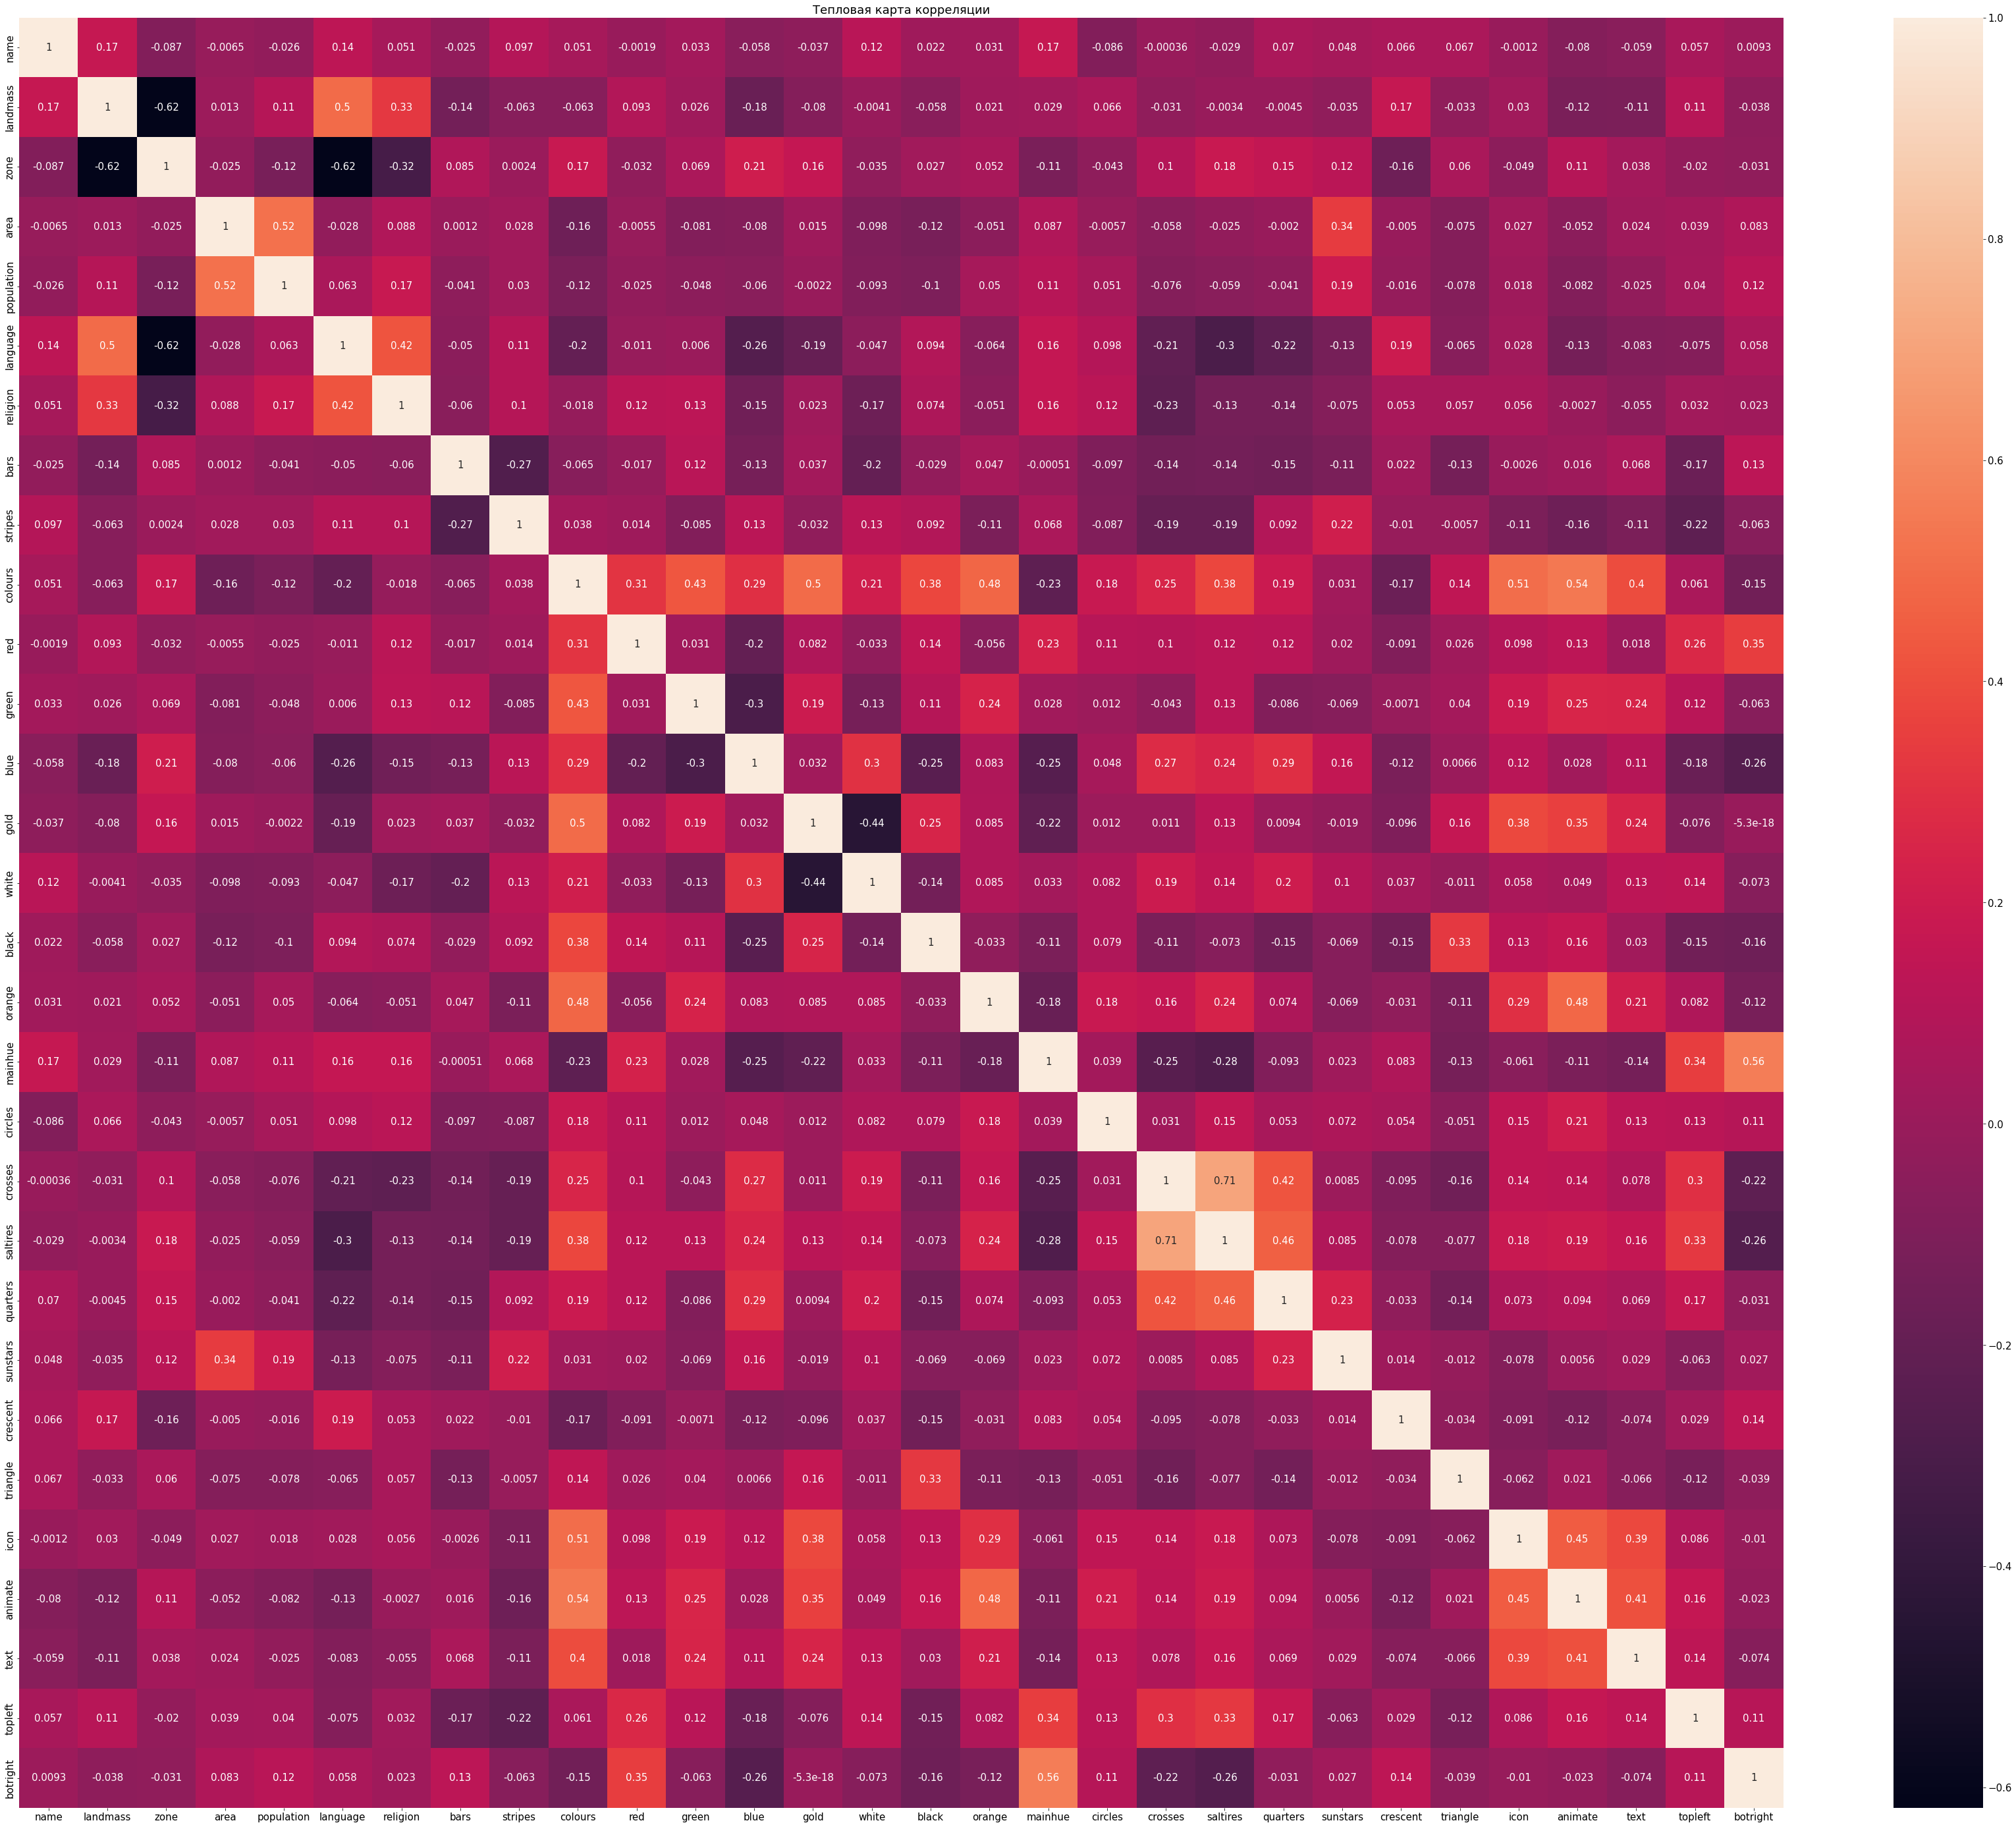

In [226]:
plt.figure(figsize=(60, 50))
sns.heatmap(flags_df.corr(), annot=True)
plt.title('Тепловая карта корреляции')
plt.show()

> Как мы можем видеть, есть 2 пары признакой со средней отрицательной корреляцией, в остальных случаях она не очень большая.

## 5. Визуализация распределения каждой перемнной

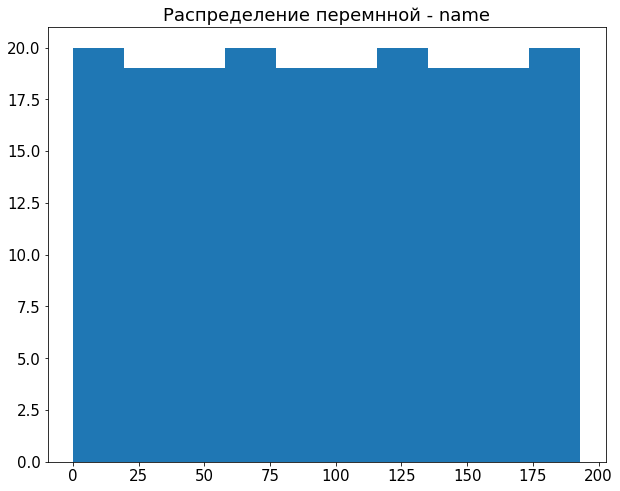

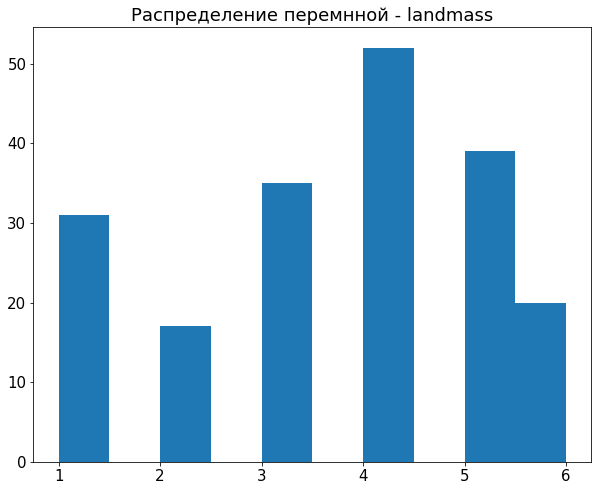

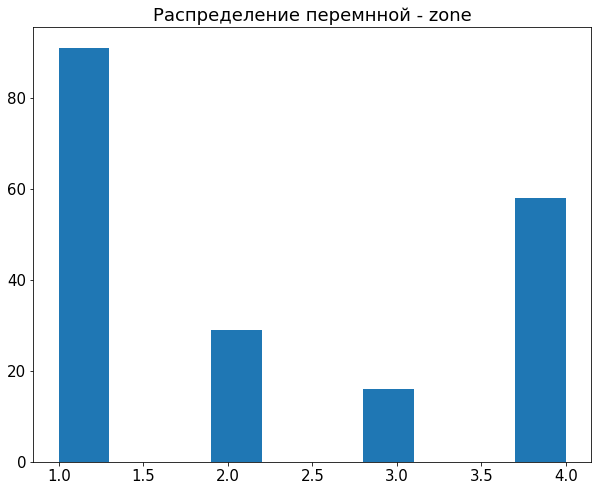

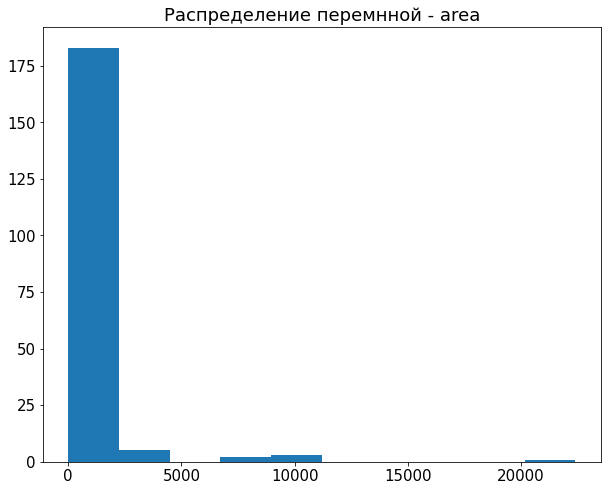

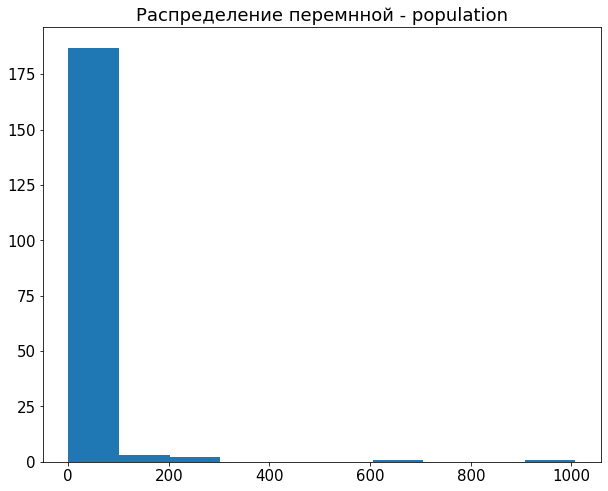

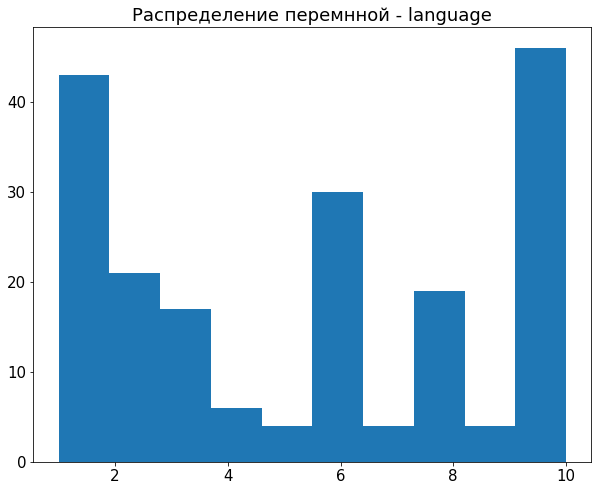

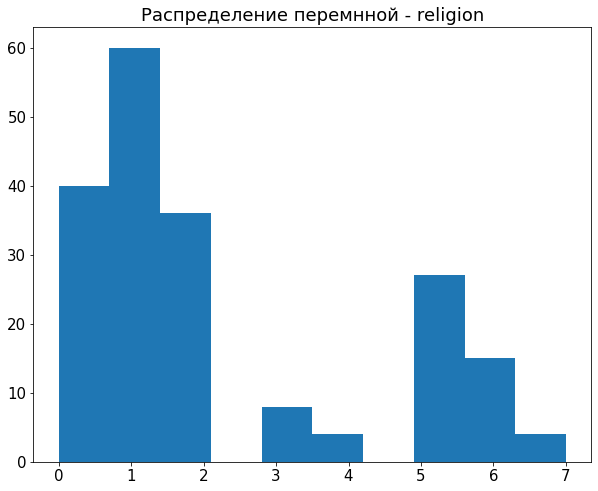

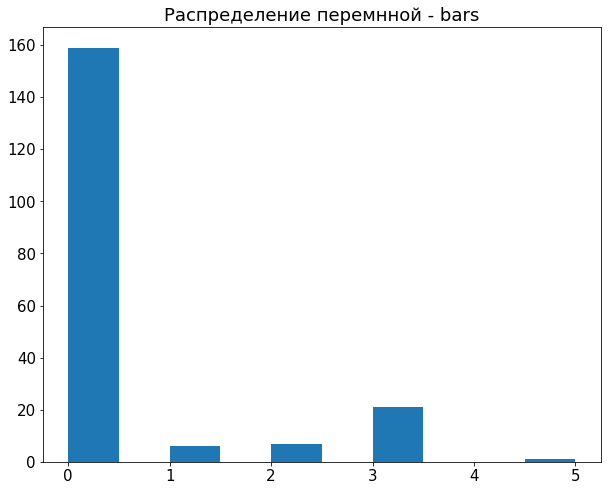

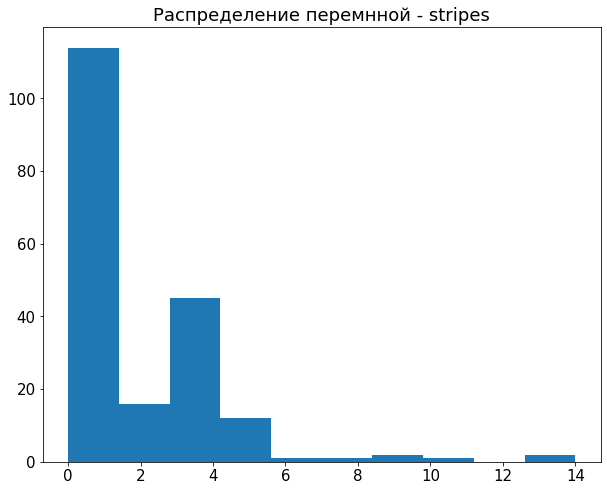

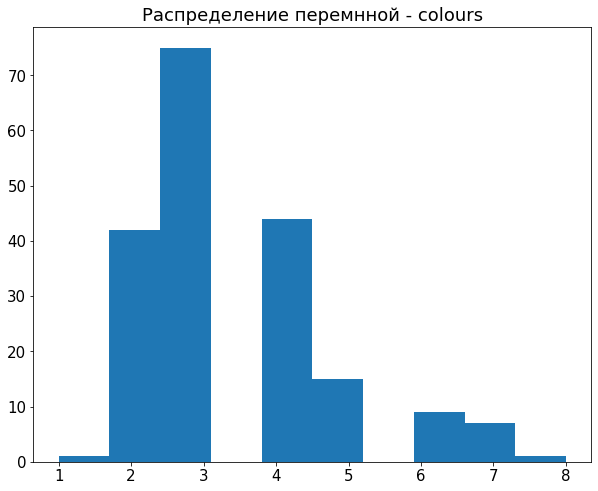

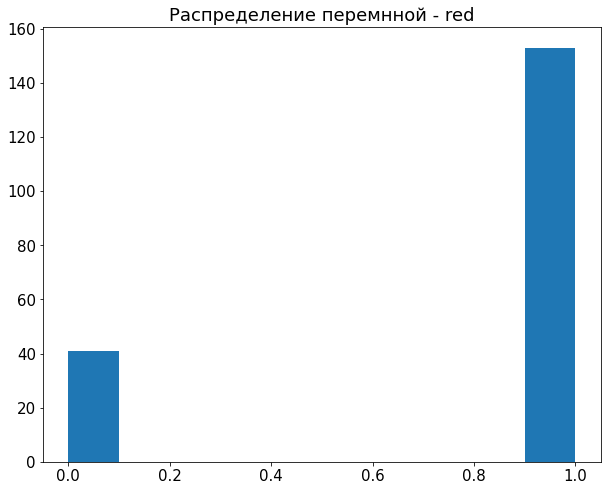

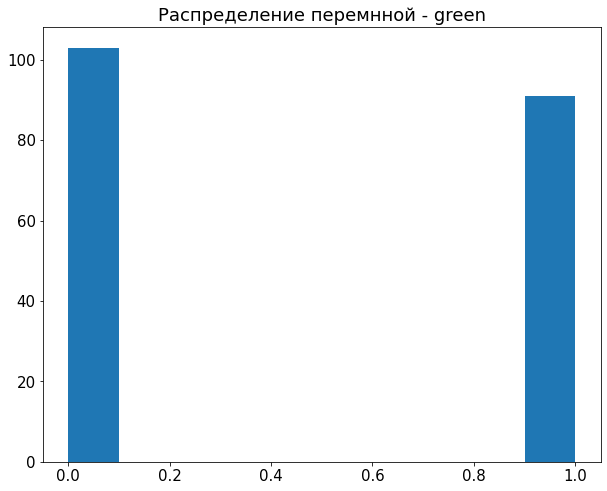

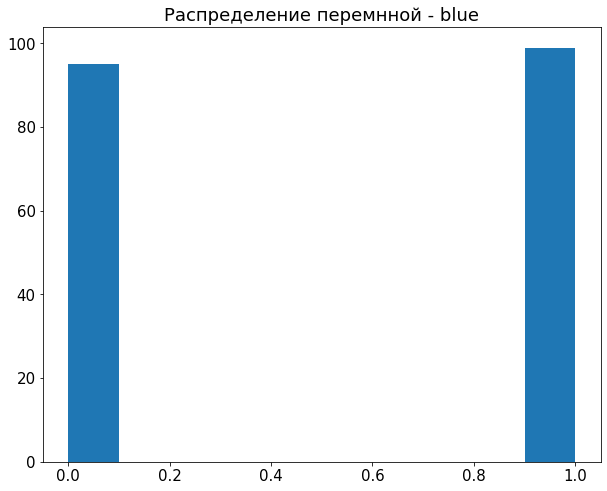

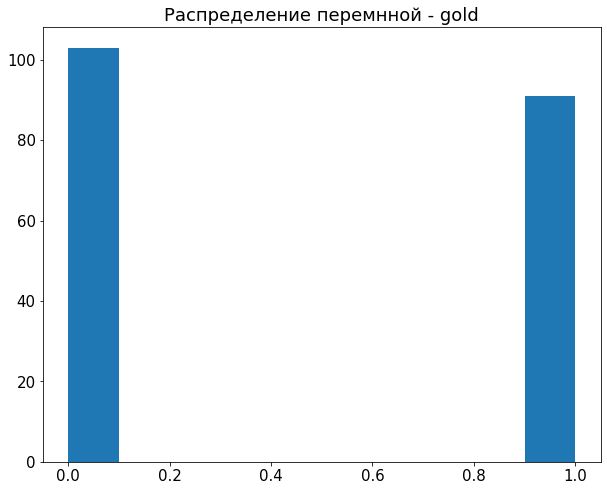

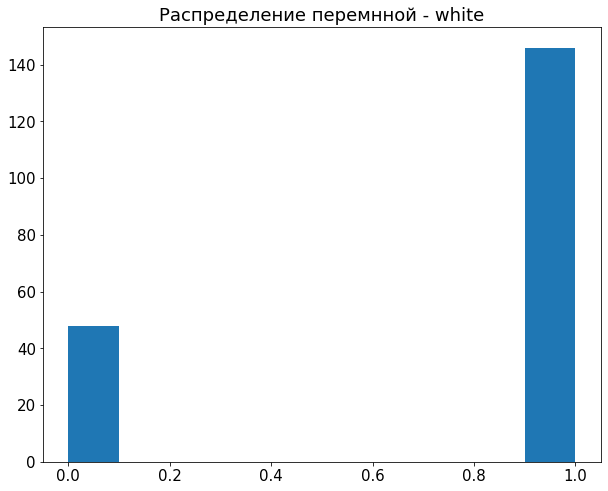

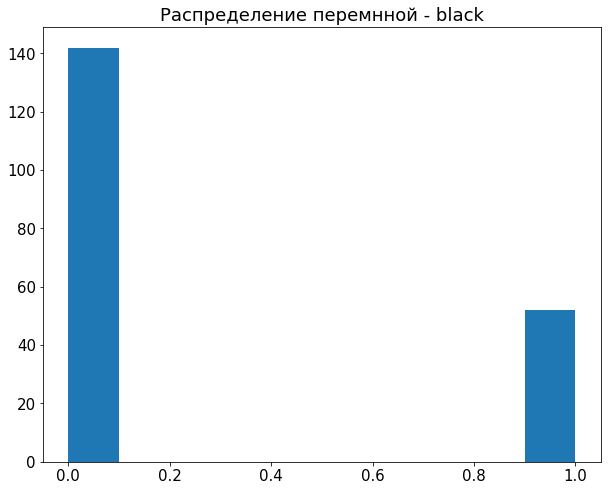

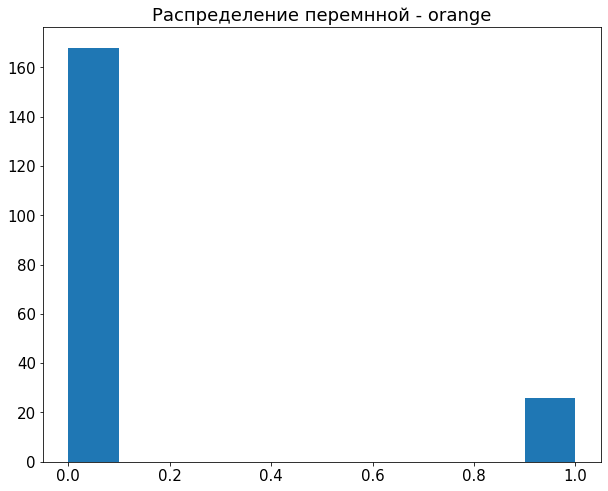

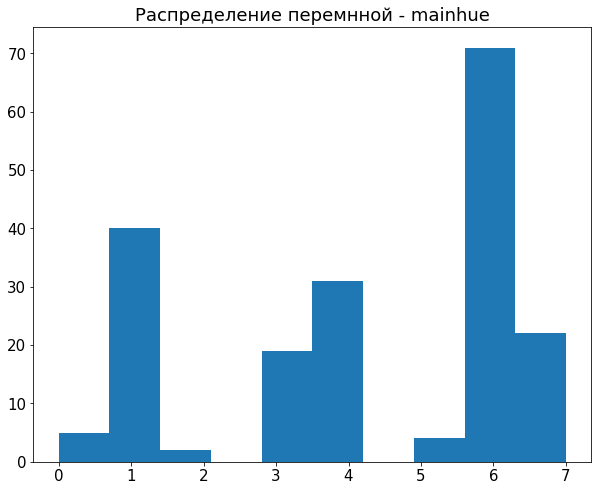

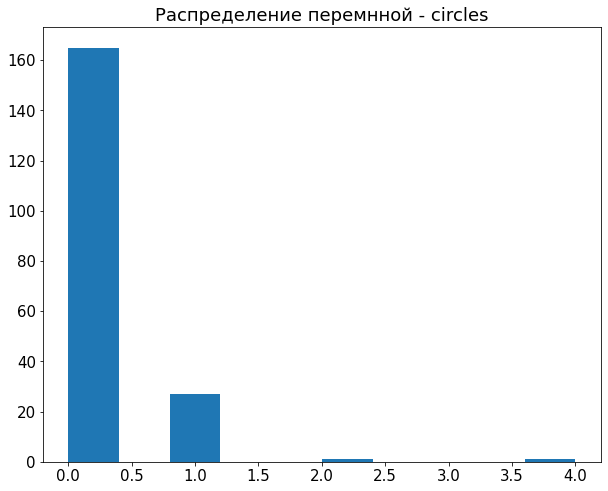

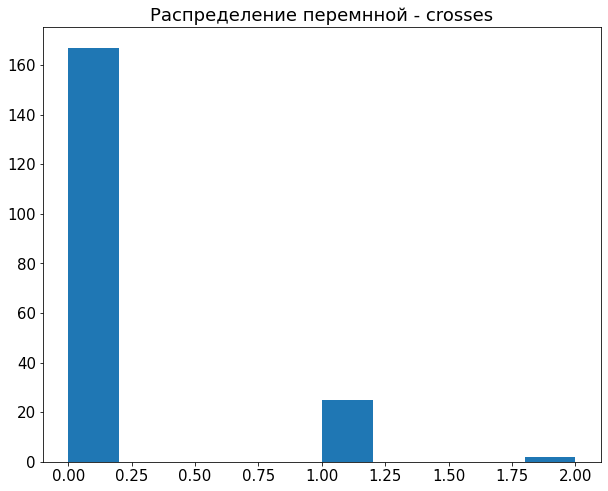

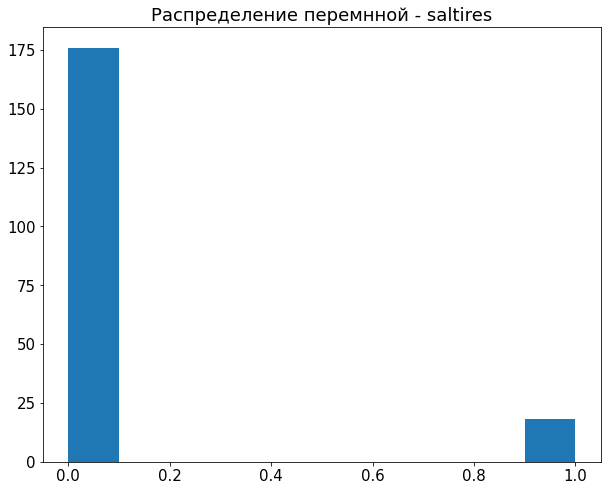

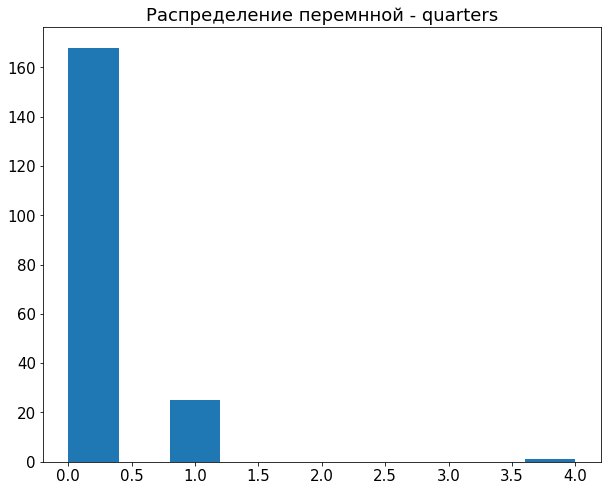

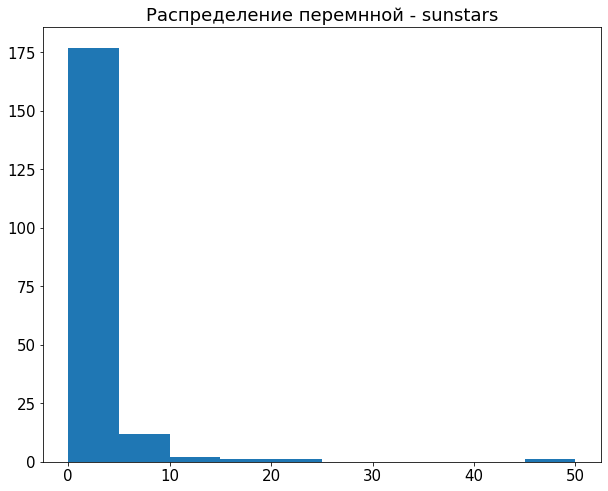

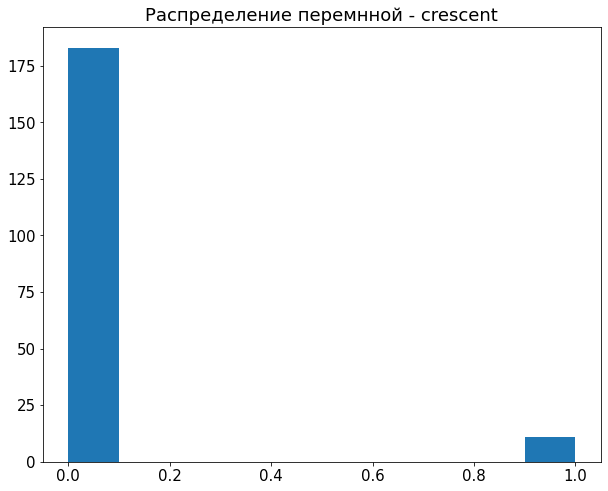

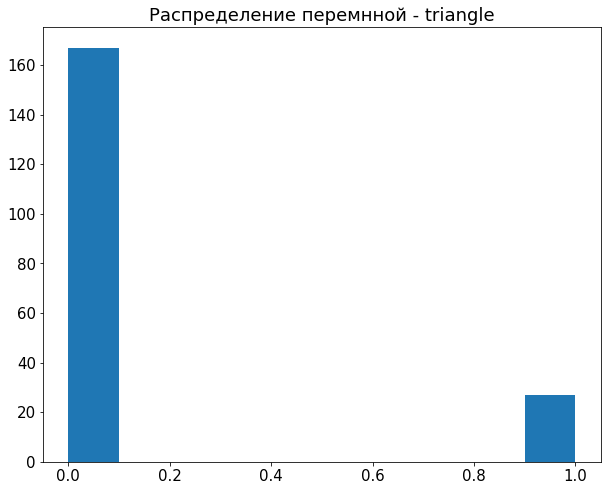

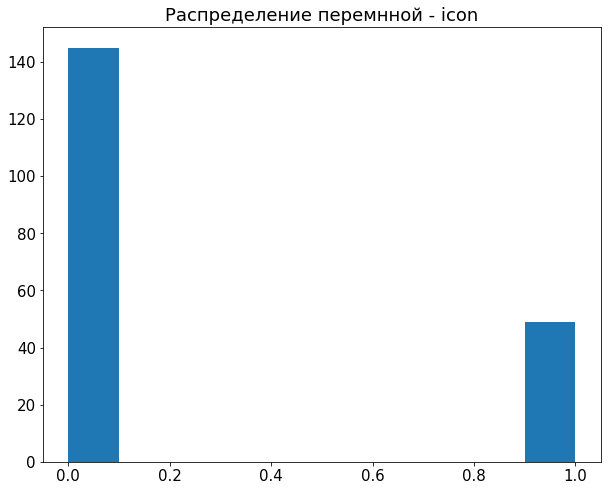

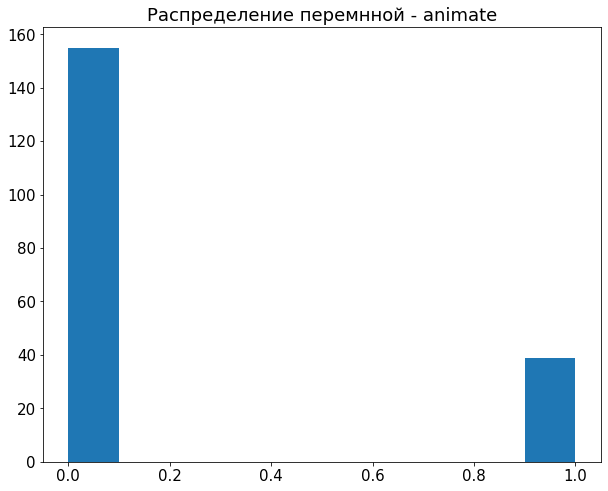

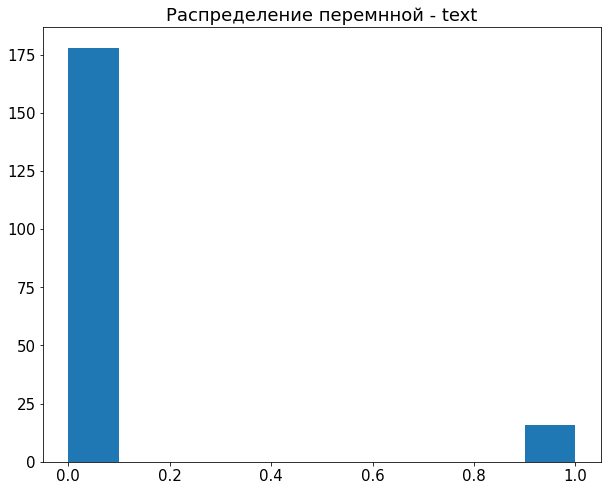

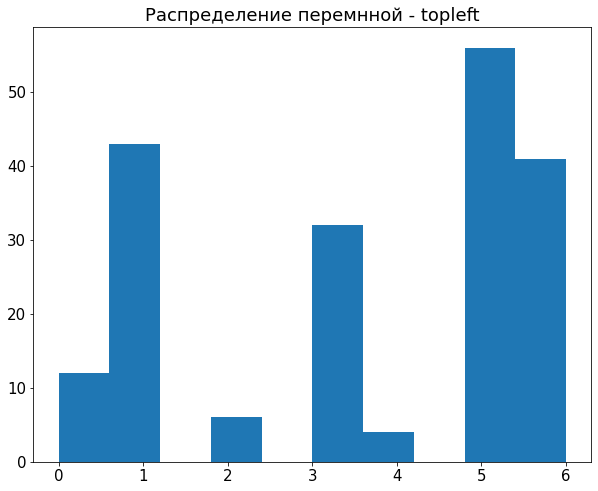

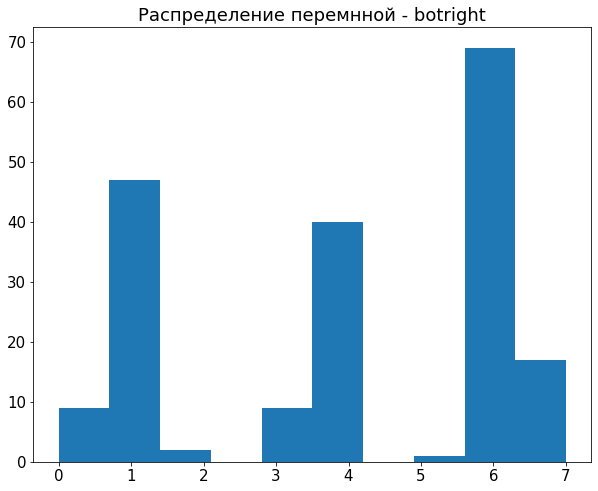

In [227]:
for feature in flags_df.columns:
    plt.figure(figsize=(10, 8))
    plt.title(f'Распределение перемнной - {feature}')
    plt.hist(flags_df[feature])
    plt.show()

> Не удаляю выбросы, потому что большинство значений категориальны, а другие значения не могут быть выбросами т.к население страны или ее площадь - это факторы который нельзя просто так удалить.

## 6. Нормализация признаков c помощью Z преобразования

Для нормализации возьмем признак area и population

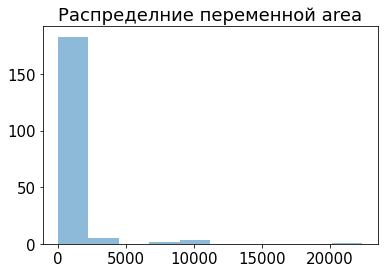

In [228]:
plt.title('Распределние переменной area')
plt.hist(flags_df['area'], alpha=0.5)
plt.show()

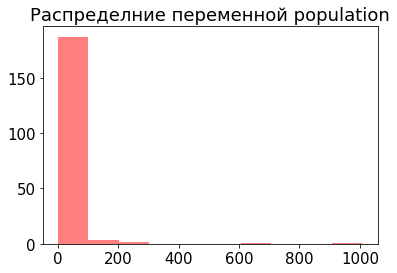

In [229]:
plt.title('Распределние переменной population')
plt.hist(flags_df['population'], alpha=0.5, color='red')
plt.show()

In [230]:
flags_df['area'] = (flags_df['area'] - flags_df['area'].mean()) / flags_df['area'].var()
flags_df['population'] = (flags_df['population'] - flags_df['population'].mean()) / flags_df['population'].var()

## 7. Обучение модели после нормализации

In [231]:
X = flags_df.drop('religion', axis=1)
y = flags_df['religion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression().fit(X_train, y_train)
y_true = y_test
y_pred = log_reg_model.predict(X_test)

result_table = pd.concat([result_table, get_metrics(y_true, y_pred, 'norm. data')])

In [232]:
result_table

,processing_name,accuracy,recall,precision,f1_score
0,without proccesing,0.410256,0.166667,0.189286,0.158673
0,norm. data,0.384615,0.207540,0.258854,0.223701


## 8. Устранение дисбаланса классов путем undersampling

In [233]:
flags_df['religion'].value_counts()

1    60
0    40
2    36
5    27
6    15
3     8
4     4
7     4
Name: religion, dtype: int64

Как мы видим в класса присутствует дисбаланс

In [234]:
X = flags_df.drop('religion', axis=1)
y = flags_df['religion']

undersample = RandomUnderSampler(sampling_strategy='majority')

X, y = undersample.fit_resample(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 8.1 Обучение модели после устранения дисбаланса классов

In [235]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
y_true = y_test
y_pred = log_reg_model.predict(X_test)

In [237]:
result_table = pd.concat([result_table, get_metrics(y_pred, y_true, 'remove of imbalance')])

## 9. Уменьшение размера простаранства признаков

Для способа отбора признаков, возьмем просто алгоритм перебора

In [270]:
sfs = SequentialFeatureSelector(
        estimator=LogisticRegression(max_iter=1000),
        n_features_to_select='auto'
    ).fit(X, y)

In [274]:
X_train = sfs.transform(X_train)
X_test = sfs.transform(X_test)


log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
y_true = y_test
y_pred = log_reg_model.predict(X_test)

In [276]:
result_table = pd.concat([result_table, get_metrics(y_true, y_pred, 'SequentialFeatureSelector')])

## 10. Оптимизация модели логистической регрсиии

In [287]:
parametrs = {
    'multi_class': ('auto', 'ovr', 'multinomial'),
    'l1_ratio': np.arange(0, 1.1, 0.1),
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}
log_reg_model = LogisticRegression().fit(X_train, y_train)
grid_search = GridSearchCV(log_reg_model, parametrs).fit(X_train, y_train)

In [288]:
log_reg_model = log_reg_model.set_params(**grid_search.best_params_).fit(X_train, y_train)
y_pred = log_reg_model.predict(X_test)
y_true = y_test

In [291]:
result_table = pd.concat([result_table, get_metrics(y_pred, y_true, 'GridSearch')])

## 11. Стекинг трех моделей

In [305]:
estimators = {
    ('RandomForest', RandomForestClassifier()),
    ('Tree', DecisionTreeClassifier())
}
stacking_of_model = StackingClassifier(estimators, final_estimator=LogisticRegression(**grid_search.best_params_))
stacking_of_model.fit(X_train, y_train)

StackingClassifier(estimators={('RandomForest', RandomForestClassifier()),
                               ('Tree', DecisionTreeClassifier())},
                   final_estimator=LogisticRegression(C=1000.0, l1_ratio=0.0))

In [307]:
y_true = y_test
y_pred = stacking_of_model.predict(X_test)

result_table = pd.concat([result_table, get_metrics(y_true, y_pred, 'StackingOfModel')])

In [308]:
result_table

,processing_name,accuracy,recall,precision,f1_score
0,without proccesing,0.410256,0.166667,0.189286,0.158673
0,norm. data,0.384615,0.207540,0.258854,0.223701
0,remove of imbalance,0.391304,0.224490,0.196429,0.205617
0,SequentialFeatureSelector,0.434783,0.277778,0.263946,0.237095
0,GridSearch,0.521739,0.321088,0.422619,0.332025
0,StackingOfModel,0.608696,0.380952,0.465306,0.382468


## Итоги

In [335]:
print(f'{stacking_of_model.classes_} - метки классов')
print(' - - - - - - - - ')
matrix = confusion_matrix(y_true, y_pred, labels=stacking_of_model.classes_)
for i in range(len(matrix)):
    print(f'{matrix[i]} для класса {i}')

[0 1 2 3 4 5 6 7] - метки классов
 - - - - - - - - 
[6 0 0 0 0 0 1 0] для класса 0
[1 0 0 0 0 0 0 0] для класса 1
[0 0 4 0 0 0 0 1] для класса 2
[0 1 1 0 0 0 0 1] для класса 3
[0 0 0 0 0 0 0 0] для класса 4
[1 0 0 0 0 3 0 1] для класса 5
[0 0 1 0 0 0 0 0] для класса 6
[0 0 0 0 0 0 0 1] для класса 7
